In [1]:
import json
import os
import time
import ipyparallel as ipp

import matplotlib.pyplot as plt
import torch
import dfca as DFCA
import ifca as IFCA

import numpy as np

from util import *

Reads Config file and prepares the arguments you can choose in the config_dfca.json/config_ifca.json

In [2]:
rc = ipp.Cluster(n=3).start_and_connect_sync()
rc.activate()

rc.ids 

dview = rc[:]

Starting 3 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/3 [00:00<?, ?engine/s]

In [3]:
learning_rates = [0.25]

dfca_li = []
dfca_gi = []
ifca = []

In [4]:
%%px --targets all

import sys
import os
import random
sys.path.append(os.getcwd())

random.seed(42)
seeds = random.sample(range(10000), 5)
learning_rates = [0.25]

dfca_li = []
dfca_gi = []
ifca = []

Running the dfca-gi experiment

In [5]:
%%px --target 0 --noblock
import dfca as DFCA
import json
import time
import torch
import numpy as np


with open("config_dfca_gi.json", "r") as read_file:
    config = json.load(read_file)

for lr in learning_rates:
    config['lr'] = lr
    res_final = []

    for seed in seeds:
        print(f"---------------------------------DFCA-LI, lr: {lr}, seed: {seed}---------------------------------")
        start_time = time.time()
        config['data_seed'] = seed
        config['train_seed'] = config['data_seed']

        print("config:",config)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        exp = DFCA.TrainEMNISTCluster(config, device)
        exp.setup()
        res = exp.run()
        res_final.append([[r['test']['loss'] for r in res], [r['test']['acc'] for r in res], [r['test']['cl_acc'] for r in res]])
        del exp
        duration = (time.time() - start_time)
        print("---train cluster Ended in %0.2f hour (%.3f sec) " % (duration/float(3600), duration))

    res_mean = np.mean(res_final, axis=0).tolist()
    dfca_gi.append(res_mean)



<AsyncResult(%px): pending>

Running the dfca-li experiment


In [6]:
%%px --target 1 --noblock
import dfca as DFCA
import json
import time
import torch
import numpy as np


with open("config_dfca_li.json", "r") as read_file:
    config = json.load(read_file)

for lr in learning_rates:
    config['lr'] = lr
    res_final = []

    for seed in seeds:
        print(f"---------------------------------DFCA-LI, lr: {lr}, seed: {seed}---------------------------------")
        start_time = time.time()
        config['data_seed'] = seed
        config['train_seed'] = config['data_seed']

        print("config:",config)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        exp = DFCA.TrainEMNISTCluster(config, device)
        exp.setup()
        res = exp.run()
        res_final.append([[r['test']['loss'] for r in res], [r['test']['acc'] for r in res], [r['test']['cl_acc'] for r in res]])
        del exp
        duration = (time.time() - start_time)
        print("---train cluster Ended in %0.2f hour (%.3f sec) " % (duration/float(3600), duration))

    res_mean = np.mean(res_final, axis=0).tolist()
    dfca_li.append(res_mean)



<AsyncResult(%px): pending>

Running the ifca experiment

In [7]:
%%px --target 2 --noblock
import ifca as IFCA
import json
import time
import torch
import numpy as np

with open("config_ifca.json", "r") as read_file:
    config = json.load(read_file)

for lr in learning_rates:
    config['lr'] = lr
    res_final = []

    for seed in seeds:
        print(f"---------------------------------IFCA, lr: {lr}, seed: {seed}---------------------------------")
        start_time = time.time()
        config['data_seed'] = seed
        config['train_seed'] = config['data_seed']

        print("config:",config)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        exp = IFCA.TrainEMNISTCluster(config, device)
        exp.setup()
        res = exp.run()
        res_final.append([[r['test']['loss'] for r in res], [r['test']['acc'] for r in res], [r['test']['cl_acc'] for r in res]])
        del exp
        duration = (time.time() - start_time)
        print("---train cluster Ended in %0.2f hour (%.3f sec) " % (duration/float(3600), duration))

    res_mean = np.mean(res_final, axis=0).tolist()
    ifca.append(res_mean)



<AsyncResult(%px): pending>

Experiment Final Results: 

In [8]:
rc.wait_interactive()
_.display_outputs()

dfca_gi = rc[0].pull('dfca_gi', block=True)
dfca_li = rc[1].pull('dfca_li', block=True)
ifca = rc[2].pull('ifca', block=True)

unknown:   0%|          | 0/3 [00:00<?, ?tasks/s]

---------------------------------IFCA, lr: 0.25, seed: 1824---------------------------------
config: {'m': 200, 'm_test': 40, 'p': 2, 'n': 500, 'uneven': False, 'h1': 200, 'num_epochs': 300, 'batch_size': 100, 'tau': 5, 'lr': 0.25, 'data_seed': 1824, 'train_seed': 1824, 'config_override': '', 'project_dir': 'output_ifca'}
Using device: cuda
Epoch -1 tr: l 3.850 a 0.024 clct[np.int64(121), np.int64(79)] cl_acc 0.555  2.740sec
Epoch -1 tst: l 3.850 a 0.023 clct[np.int64(25), np.int64(15)] cl_acc 0.575  0.525sec
Epoch 0 tr: l 3.841 a 0.028 clct[np.int64(66), np.int64(134)] cl_acc 0.590  lr 0.250000 12.337sec(train) 4.023sec(infer)
Epoch 0 tst: l 3.841 a 0.028 clct[np.int64(9), np.int64(31)] cl_acc 0.575  0.639sec
result written at output_ifca/results.pickle
checkpoint written at output_ifca/checkpoint.pt
Epoch 1 tr: l 3.823 a 0.071 clct[np.int64(17), np.int64(183)] cl_acc 0.575  lr 0.250000 13.264sec(train) 5.130sec(infer)
Epoch 1 tst: l 3.824 a 0.069 clct[np.int64(1), np.int64(39)] cl_ac

In [9]:
__.display_outputs()

---------------------------------DFCA-LI, lr: 0.25, seed: 1824---------------------------------
config: {'m': 200, 'm_test': 40, 'p': 2, 'n': 500, 'uneven': False, 'local_model_init': True, 'h1': 200, 'num_epochs': 300, 'batch_size': 100, 'tau': 5, 'lr': 0.25, 'data_seed': 1824, 'train_seed': 1824, 'config_override': '', 'project_dir': 'output_dfca_li'}
Using device: cuda
<class 'list'>
<class 'list'>
Epoch -1 tr: l 3.850 a 0.023 clct[np.int64(100), np.int64(100)] cl_acc 0.510  4.338sec
Epoch -1 tst: l 3.850 a 0.025 clct[np.int64(19), np.int64(21)] cl_acc 0.575  3.141sec
Epoch 0 tr: l 3.846 a 0.030 clct[np.int64(104), np.int64(96)] cl_acc 0.510  lr 0.250000 14.098sec(train) 4.732sec(infer)
Epoch 0 tst: l 3.850 a 0.025 clct[np.int64(18), np.int64(22)] cl_acc 0.650  3.286sec
result written at output_dfca_li/results.pickle
checkpoint written at output_dfca_li/checkpoint.pt
Epoch 1 tr: l 3.848 a 0.028 clct[np.int64(101), np.int64(99)] cl_acc 0.515  lr 0.249875 11.786sec(train) 4.205sec(inf

In [10]:
___.display_outputs()

---------------------------------DFCA-LI, lr: 0.25, seed: 1824---------------------------------
config: {'m': 200, 'm_test': 40, 'p': 2, 'n': 500, 'uneven': False, 'local_model_init': False, 'h1': 200, 'num_epochs': 300, 'batch_size': 100, 'tau': 5, 'lr': 0.25, 'data_seed': 1824, 'train_seed': 1824, 'config_override': '', 'project_dir': 'output_dfca_gi'}
Using device: cuda
<class 'list'>
<class 'list'>
Epoch -1 tr: l 3.850 a 0.024 clct[np.int64(108), np.int64(92)] cl_acc 0.600  2.791sec
Epoch -1 tst: l 3.851 a 0.026 clct[np.int64(21), np.int64(19)] cl_acc 0.625  1.943sec
Epoch 0 tr: l 3.833 a 0.041 clct[np.int64(77), np.int64(123)] cl_acc 0.615  lr 0.250000 11.796sec(train) 3.595sec(infer)
Epoch 0 tst: l 3.840 a 0.039 clct[np.int64(11), np.int64(29)] cl_acc 0.625  2.572sec
result written at output_dfca_gi/results.pickle
checkpoint written at output_dfca_gi/checkpoint.pt
Epoch 1 tr: l 3.806 a 0.058 clct[np.int64(38), np.int64(162)] cl_acc 0.630  lr 0.249875 13.252sec(train) 4.229sec(inf

{'test_loss': [[3.8505428993701933, 3.8374386227130883, 3.8059906208515173, 3.70621060013771, 3.628162162303924, 3.4623587167263032, 3.544055734872818, 3.3727018249034884, 3.2029617440700533, 3.402703380584717, 3.124826676845551, 3.10045472741127, 2.8216445207595826, 3.004752123355865, 2.650877760648727, 2.5569736075401304, 2.575115044116974, 2.350368390083313, 2.27070142865181, 2.1454311859607698, 2.041921776533127, 2.075964585542679, 2.009175266623497, 1.8976256531476974, 1.781508429646492, 1.7168644294142723, 1.6314775964617731, 1.6151136276125908, 1.5430133336782454, 1.4611820304393768, 1.4729330587387086, 1.3970583817362785, 1.3876249477267266, 1.326222585439682, 1.3001501923799514, 1.2518766194581985, 1.2561061730980874, 1.2331106382608414, 1.1844971993565558, 1.1806513160467147, 1.1466967809200288, 1.1426928782463075, 1.1063838523626326, 1.0916681507229804, 1.0868009713292122, 1.0664440631866454, 1.0632919695973395, 1.038617185652256, 1.0227528575062752, 1.006500314772129, 1.003

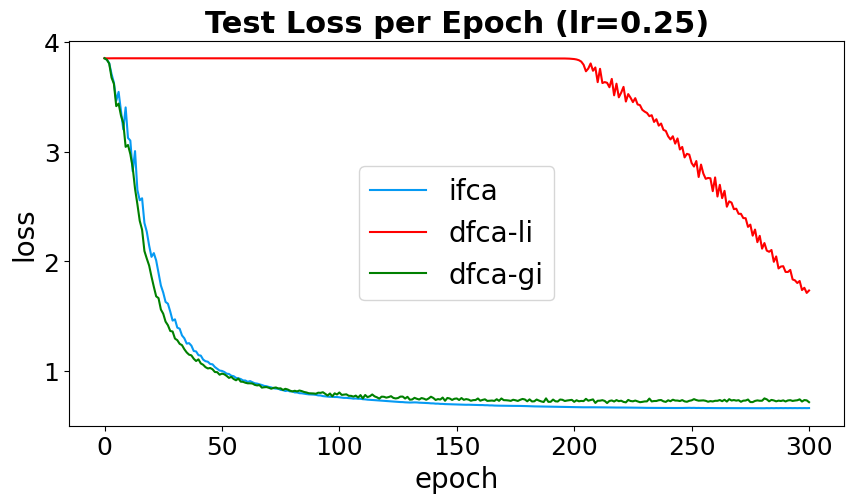

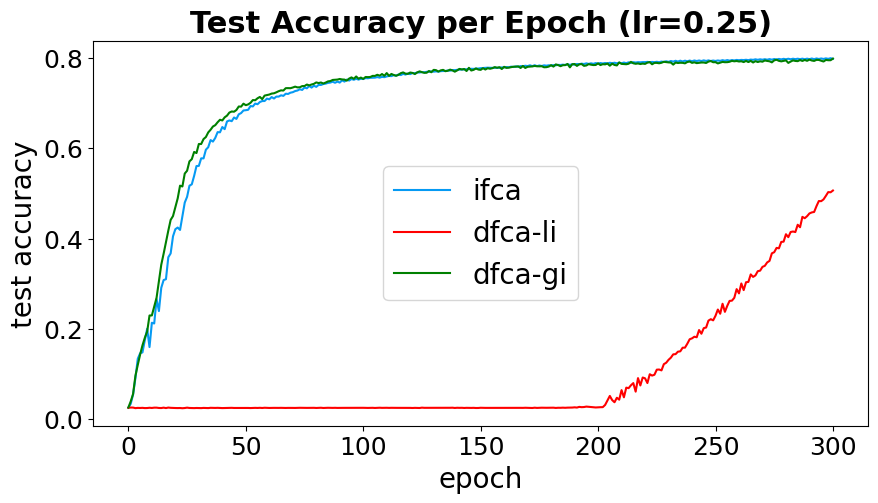

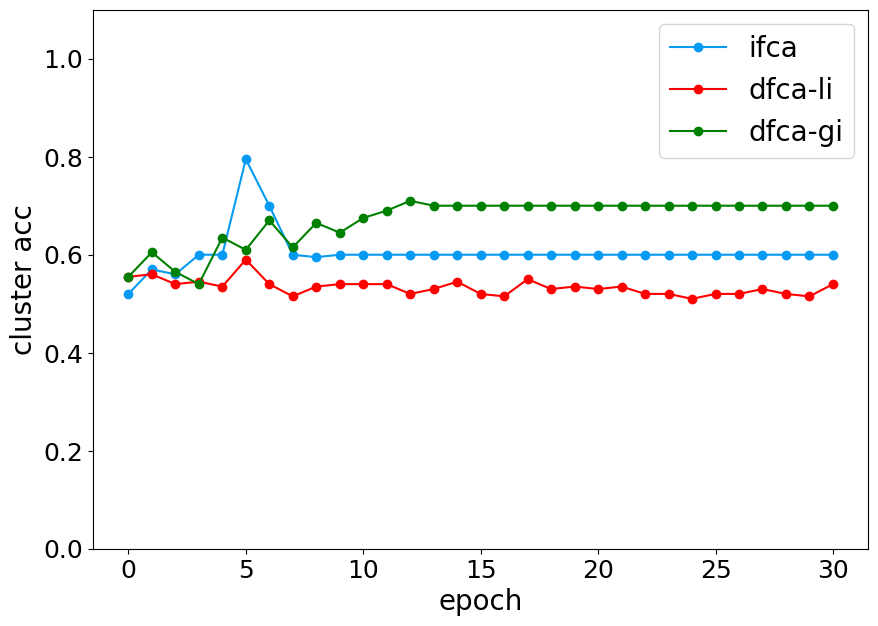

In [11]:

r_ifca = {}
r_dfca_gi = {}
r_dfca_li = {}

r_ifca['test_loss'] = []
r_ifca['test_acc'] = []
r_ifca['cl_acc'] = []
for i in range(len(learning_rates)):
    r_ifca['test_loss'].append(ifca[i][0])
    r_ifca['test_acc'].append(ifca[i][1])
    r_ifca['cl_acc'].append(ifca[i][2])

r_dfca_gi['test_loss'] = []
r_dfca_gi['test_acc'] = []
r_dfca_gi['cl_acc'] = []
for i in range(len(learning_rates)):
    r_dfca_gi['test_loss'].append(dfca_gi[i][0])
    r_dfca_gi['test_acc'].append(dfca_gi[i][1])
    r_dfca_gi['cl_acc'].append(dfca_gi[i][2])

r_dfca_li['test_loss'] = []
r_dfca_li['test_acc'] = []
r_dfca_li['cl_acc'] = []
for i in range(len(learning_rates)):
    r_dfca_li['test_loss'].append(dfca_li[i][0])
    r_dfca_li['test_acc'].append(dfca_li[i][1])
    r_dfca_li['cl_acc'].append(dfca_li[i][2])

print(r_ifca)

os.makedirs('graphs', exist_ok=True)

for l in range(len(learning_rates)):

    plt.figure(figsize=(10,5))
    plt.plot(r_ifca['test_loss'][l], label='ifca', color='xkcd:azure')
    plt.plot(r_dfca_li['test_loss'][l], label='dfca-li', color='red')
    plt.plot(r_dfca_gi['test_loss'][l], label='dfca-gi', color='green')
    plt.xlabel('epoch', fontsize=20)
    plt.ylabel('loss', fontsize=20)
    plt.title(f'Test Loss per Epoch (lr={learning_rates[l]})', fontsize=22, fontweight='bold')
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.legend(fontsize=20)
    plt.savefig(os.path.join('graphs', 'train_loss.png'))

    plt.figure(figsize=(10,5))
    plt.plot(r_ifca['test_acc'][l], label='ifca', color='xkcd:azure')
    plt.plot(r_dfca_li['test_acc'][l], label='dfca-li', color='red')
    plt.plot(r_dfca_gi['test_acc'][l], label='dfca-gi', color='green')
    plt.xlabel('epoch', fontsize=20)
    plt.ylabel('test accuracy', fontsize=20)
    plt.title(f'Test Accuracy per Epoch (lr={learning_rates[l]})', fontsize=22, fontweight='bold')
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.legend(fontsize=20)
    plt.savefig(os.path.join('graphs', 'test_acc.png'))

    plt.figure(figsize=(10,7))
    plt.ylim([0, 1.1])
    plt.plot(r_ifca['cl_acc'][l][:31], label='ifca', color='xkcd:azure', marker='o')
    plt.plot(r_dfca_li['cl_acc'][l][:31], label='dfca-li', color='red', marker='o')
    plt.plot(r_dfca_gi['cl_acc'][l][:31], label='dfca-gi', color='green', marker='o')
    plt.xlabel('epoch', fontsize=20)
    plt.ylabel('cluster acc', fontsize=20)
    plt.legend(fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.savefig(os.path.join('graphs', 'cluster_acc.png'))